In [ ]:
# Import the library to mount Google Drive
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import library
import numpy as np
import pandas as pd
import re, string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow
from tqdm import tqdm
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import clear_output
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load the data
# Define the file path
file_path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'

# Read the CSV file into a pandas DataFrame
odf = pd.read_csv(file_path, encoding='latin-1')

# Display the first few rows of the DataFrame
print(odf.head())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [ ]:
odf

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
# change columns name
odf.columns = ['sentiment','id','date','query','user_id','text']
# drop unimportant columns
odf = odf.drop(['id','date','query','user_id'], axis =1)
odf.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [ ]:
# change 0 and 4 to positive and negative
sentiment = {0:"negative",4:"positive"}
def label_decoder(label):
    return sentiment[label]

odf['sentiment'] = odf['sentiment'].apply(lambda x: label_decoder(x))

In [ ]:
# drop duplicates rows
odf.drop_duplicates(inplace = True)
odf.head()

,sentiment,text
0,negative,is upset that he can't update his Facebook by ...
1,negative,@Kenichan I dived many times for the ball. Man...
2,negative,my whole body feels itchy and like its on fire
3,negative,"@nationwideclass no, it's not behaving at all...."
4,negative,@Kwesidei not the whole crew


In [ ]:
import pandas as pd

# Shuffle the DataFrame
df_shuffled = odf.sample(frac=1, random_state=1).reset_index(drop=True)

# Separate positive and negative samples
positive_samples = df_shuffled[df_shuffled['sentiment'] == 'positive']
negative_samples = df_shuffled[df_shuffled['sentiment'] == 'negative']

# Take 50,000 samples from each
positive_sampled = positive_samples.sample(n=50000, random_state=1)
negative_sampled = negative_samples.sample(n=50000, random_state=1)

# Combine the samples
df = pd.concat([positive_sampled, negative_sampled])

# Shuffle the final sample to mix positive and negative
df = df.sample(frac=1, random_state=1).reset_index(drop=True)


Text(0.5, 1.0, 'sentiment distribution')

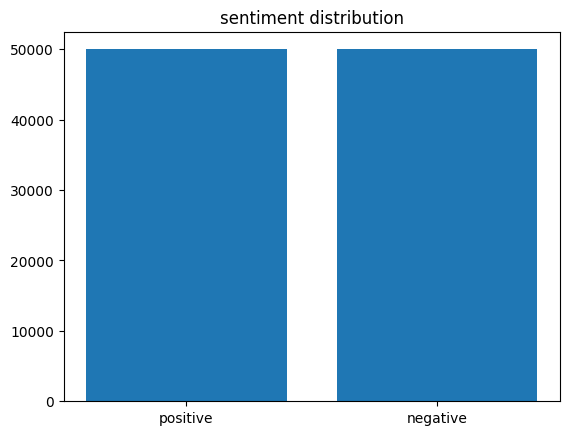

In [ ]:
# Ensuring fairness
count = df.sentiment.value_counts()
plt.bar(count.index, count.values)
plt.title('sentiment distribution')

In [ ]:
# text preprocessing
# Making Text Lowercase¶
df['text']=df['text'].str.lower()

In [ ]:
# Creating a list of English stopwords
stopwords_list = stopwords.words('english')

In [ ]:
# Converting the list of stopwords to a set for faster lookup
STOPWORDS = set(stopwords_list)
# Function to clean text by removing stopwords
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [ ]:
# Applying the cleaning_stopwords function to the 'text' column of the DataFrame
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))

In [ ]:
df['text'].head()

,text
0,uncle aunties house barbequeeee
1,@elizabetty @mbreitweiser sister discovered fo...
2,@jimmymarsh617 yep now! shitz going down!!
3,man try
4,twitter stupid!..instead increasing followers ...


In [ ]:
# Removing Emails¶
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
df['text']= df['text'].apply(lambda x: cleaning_email(x))
# Removing URLs¶
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
# Removing punctuations¶
english_punctuations = string.punctuation
english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', english_punctuations)
    return text.translate(translator)
df['text'] = df['text'].apply(lambda text: cleaning_punctuations(text))
# Removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].head()

,text
0,uncle aunties house barbequeeee
1,sister discovered form email invite get b...
2,yep now shitz going down
3,man try
4,twitter stupidinstead increasing followers dec...


In [ ]:
# Applying tokenization¶
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text
0,"[uncle, aunties, house, barbequeeee]"
1,"[sister, discovered, form, email, invite, get,..."
2,"[yep, now, shitz, going, down]"
3,"[man, try]"
4,"[twitter, stupidinstead, increasing, followers..."


In [ ]:
# Applying lemmatizer¶
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatizer_on_text(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))

df['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text
0,"[uncle, aunty, house, barbequeeee]"
1,"[sister, discovered, form, email, invite, get,..."
2,"[yep, now, shitz, going, down]"
3,"[man, try]"
4,"[twitter, stupidinstead, increasing, follower,..."


In [ ]:
df

,sentiment,text
0,positive,"[uncle, aunty, house, barbequeeee]"
1,negative,"[sister, discovered, form, email, invite, get,..."
2,positive,"[yep, now, shitz, going, down]"
3,negative,"[man, try]"
4,negative,"[twitter, stupidinstead, increasing, follower,..."
...,...,...
99995,negative,"[im, tired, texted, sarah, realized, time, is,..."
99996,negative,"[hr, im, contagious, nomore, b, friday, even, ..."
99997,positive,"[church, indiana, buy, funeral, home, find, de..."
99998,negative,"[getting, japanese, food, heart, teriaki, japa..."


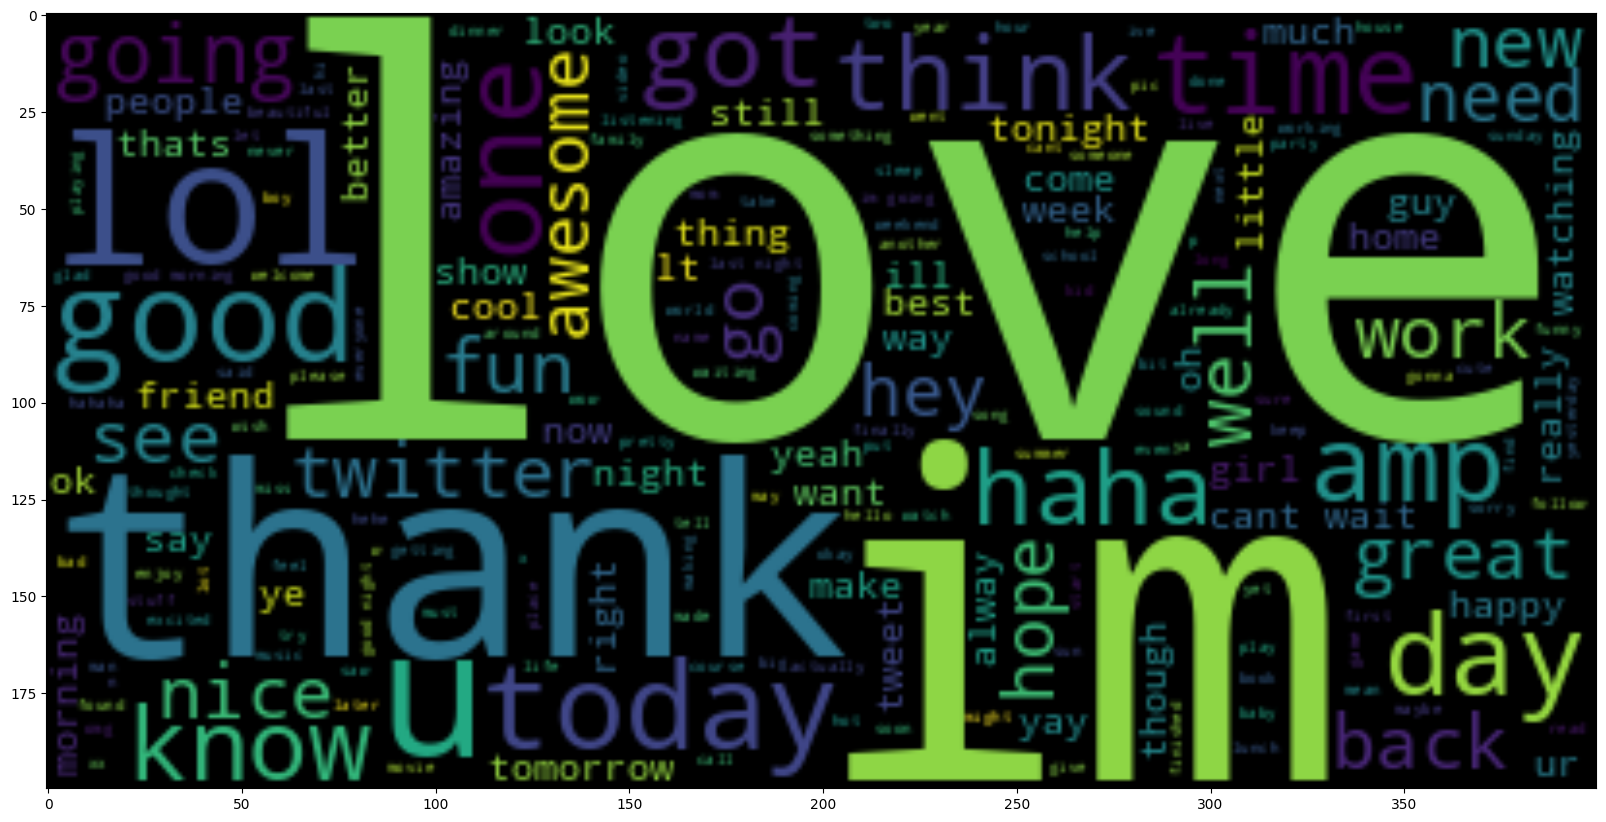

In [ ]:
# apply Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# positive texts
plt.figure(figsize = (20,20))
positive_text = " ".join([" ".join(words) for words in df[df.sentiment == 'positive'].text])
wc = WordCloud().generate(positive_text)
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

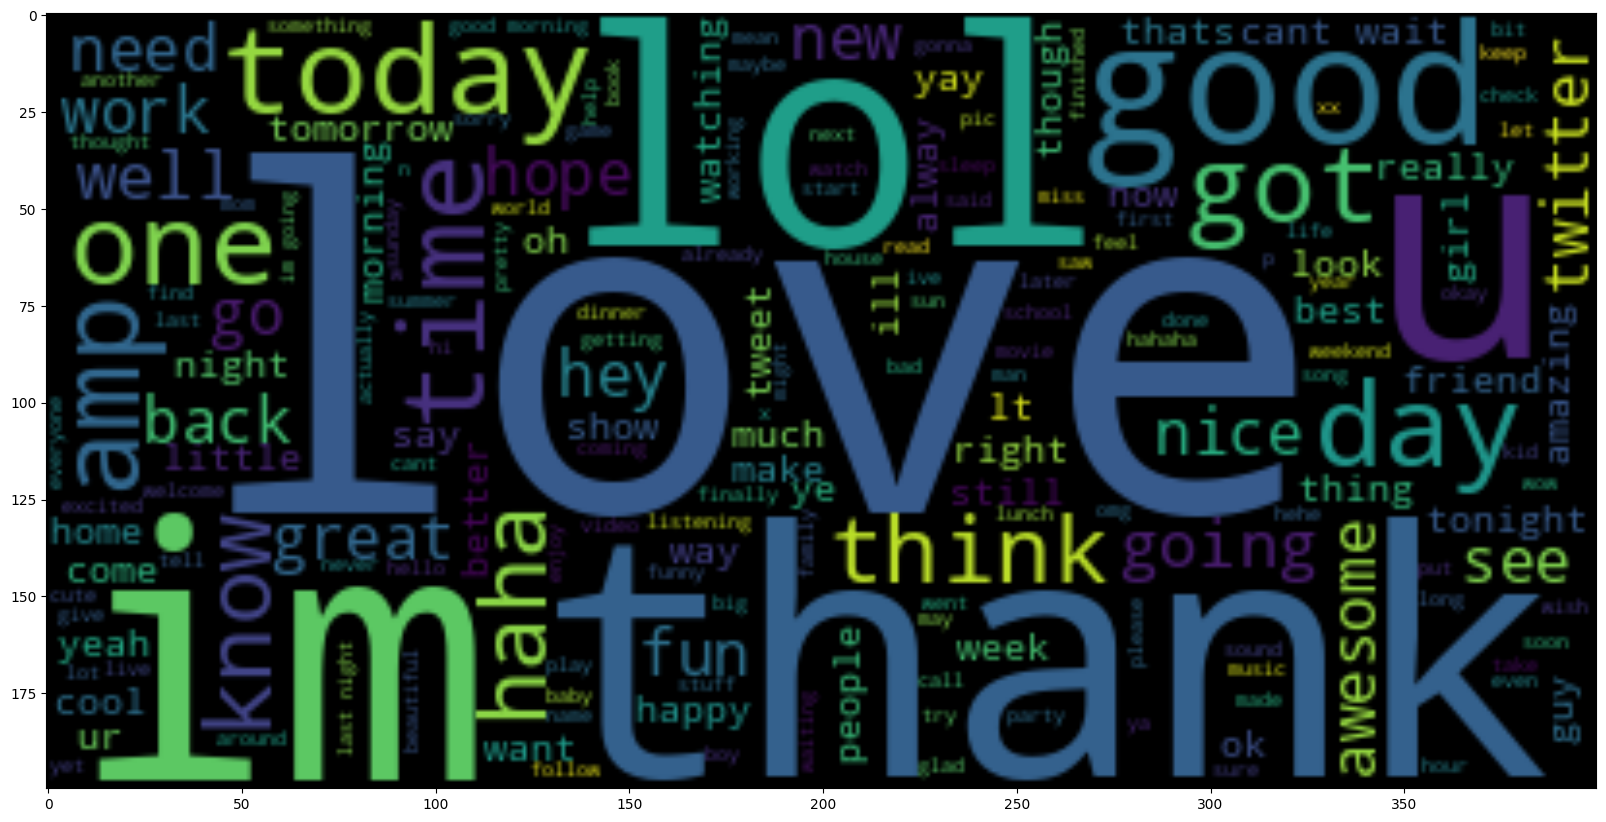

In [ ]:
# apply Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# negative texts
plt.figure(figsize = (20,20))

negative_text = " ".join([" ".join(words) for words in df[df.sentiment == 'negative'].text])
wc = WordCloud().generate(positive_text)
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

# Assuming 'text' is  feature and 'sentiment' is  target
x = df['text']  # Features
y = df['sentiment']  # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("x_train size:", len(x_train))
print("x_test size:", len(x_test))
print("y_train size:", len(y_train))
print("y_test size:", len(y_test))

x_train size: 80000
x_test size: 20000
y_train size: 80000
y_test size: 20000


In [ ]:
# Initializing the CountVectorizer to convert text data into a matrix of token counts
countvectorizer = CountVectorizer(max_features = 5000)

In [ ]:
# Using BOW
# Convert lists of words in 'text' column back to strings
x_train = x_train.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
x_test = x_test.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Fit and transform the training data, and transform the test data
x_train_bow = countvectorizer.fit_transform(x_train).toarray()
x_test_bow = countvectorizer.transform(x_test).toarray()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(x_train_bow, y_train)

# Predict using the test data
predictions = log_reg.predict(x_test_bow)

# Calculate and print the accuracy
accuracy = accuracy_score(predictions, y_test)
print(accuracy)

0.75635


In [ ]:
# Using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
x_train = x_train.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
x_test = x_test.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# apply TF-IDF
tfidf_vectorizer = TfidfVectorizer()
# Fit and transform the training data, and transform the test data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()
x_test_tfidf = tfidf_vectorizer.transform(x_test).toarray()

In [ ]:
# Using Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(x_train_tfidf, y_train)

# Predict using the test data
predictions = log_reg.predict(x_test_tfidf)

# Calculate and print the accuracy for Logistic Regression
log_reg_accuracy = accuracy_score(predictions, y_test)
print("Logistic Regression accuracy:", log_reg_accuracy)

Logistic Regression accuracy: 0.7604
